## Se instalan las dependencias usando pip
-----

In [254]:
!pip install keras-tuner -q
!pip install pandas numpy seaborn scikit-learn tensorflow

## Se importan los elementos a usar
-----

In [383]:
import pandas as pd
import numpy as np
import seaborn as sns
import keras_tuner
from tensorflow import keras
from matplotlib import pyplot as plt
from os import path, mkdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras import Sequential
from keras.layers import Dense, Dropout, Input, Normalization, BatchNormalization
from keras.optimizers import Adam

## Se definen constantes
-----

In [384]:
# parametros usados para cargar el dataset
DATASET_COLUMNS=['sbytes', 'dbytes', 'smean', 'sload', 'ct_state_ttl', 'sttl', 'dttl', 'rate', 'dur', 'dmean']
DATASET_COLUMN_LABEL_NAME='label'
BASE_PATH = path.join('.', 'datasets', 'unsw-nb15')

# parametros usados para dividir el dataset en validation y test
VALIDATION_SIZE=0.2
RANDOM_STATE=20

# parametros usados para el entrenar el modelo
NUM_EPOCHS=45

# parametros usados para el ajuste de hiperparametros
# cantidad de modelos a probar
NUM_MODELS_TO_TEST=5
# cantidad de veces que se va a probar el modelo
NUM_TEST_PER_MODEL=2
# objetivo a maximizar / minimizar
OBJECTIVE='val_loss'
# ruta de la carpeta raíz que contiene la carpeta que va a guardar los modelos
BASE_MODEL_DIRECTORY=path.join('.')
# carpeta donde se va a guardar el modelo encontrado por keras_tuner
MODEL_DIRECTORY='models'

## Se verifica que exista la carpeta models
-----

In [302]:
MODEL_DIRECTORY_PATH = path.join(BASE_MODEL_DIRECTORY, MODEL_DIRECTORY)

if not path.exists(MODEL_DIRECTORY_PATH):
    mkdir(MODEL_DIRECTORY_PATH)

## Se definen funciones
-----

In [304]:
# basado en la selección de características del paper
# https://www.researchgate.net/publication/320944473_Towards_Developing_Network_forensic_mechanism_for_Botnet_Activities_in_the_IoT_based_on_Machine_Learning_Techniques
def load_dataset(path, columns, label_column_name):
    # se carga el archivo csv como un pandas dataframe
    df = pd.read_csv(path)
    # se quitan las etiquetas del dataset
    labels = df.pop(label_column_name)
    # se transforman a numpy array de tipo float 32
    labels = labels.to_numpy(dtype=np.float32)
    # se obtienen las características del dataframe correspondientes
    features = df[columns]
    # se transforman a numpy array de ti´po float 32
    features = features.to_numpy(dtype=np.float32)
    return features, labels

## Se cargan los vectores de características y las correspondientes etiquetas usados para entrenar el modelo
-----

In [305]:
train_features, train_labels = load_dataset(path.join(BASE_PATH, 'training.csv'), DATASET_COLUMNS, DATASET_COLUMN_LABEL_NAME)

In [306]:
print(train_features)
print(train_labels)

[[2.5800000e+02 1.7200000e+02 4.3000000e+01 ... 7.4087486e+01
  1.2147800e-01 4.3000000e+01]
 [7.3400000e+02 4.2014000e+04 5.2000000e+01 ... 7.8473373e+01
  6.4990199e-01 1.1060000e+03]
 [3.6400000e+02 1.3186000e+04 4.6000000e+01 ... 1.4170161e+01
  1.6231290e+00 8.2400000e+02]
 ...
 [1.1400000e+02 0.0000000e+00 5.7000000e+01 ... 1.1111111e+05
  9.0000003e-06 0.0000000e+00]
 [1.1400000e+02 0.0000000e+00 5.7000000e+01 ... 1.1111111e+05
  9.0000003e-06 0.0000000e+00]
 [1.1400000e+02 0.0000000e+00 5.7000000e+01 ... 1.1111111e+05
  9.0000003e-06 0.0000000e+00]]
[0. 0. 0. ... 1. 1. 1.]


## Se cargan los vectores de características y las correspondientes etiquetas usados para probar el modelo
-----

In [354]:
testing_features, testing_labels = load_dataset(path.join(BASE_PATH, 'testing.csv'), DATASET_COLUMNS, DATASET_COLUMN_LABEL_NAME)

In [355]:
print(testing_features)
print(testing_labels)

[[4.9600000e+02 0.0000000e+00 2.4800000e+02 ... 9.0909094e+04
  1.1000000e-05 0.0000000e+00]
 [1.7620000e+03 0.0000000e+00 8.8100000e+02 ... 1.2500000e+05
  8.0000000e-06 0.0000000e+00]
 [1.0680000e+03 0.0000000e+00 5.3400000e+02 ... 2.0000000e+05
  4.9999999e-06 0.0000000e+00]
 ...
 [4.6000000e+01 0.0000000e+00 4.6000000e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [4.6000000e+01 0.0000000e+00 4.6000000e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0400000e+02 0.0000000e+00 5.2000000e+01 ... 1.1111111e+05
  9.0000003e-06 0.0000000e+00]]
[0. 0. 0. ... 0. 0. 0.]


## Se divide el conjunto de prueba en validación y prueba
-----

In [356]:
test_features, validation_features, test_labels, validation_labels = train_test_split(testing_features, testing_labels, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)

In [357]:
print(len(test_labels))
print(len(validation_labels))

65865
16467


In [311]:
print(validation_features)
print(validation_labels)

[[5.6400000e+02 3.5400000e+02 5.6000000e+01 ... 2.7119986e+01
  6.2684399e-01 4.4000000e+01]
 [1.6840000e+03 1.0168000e+04 1.2000000e+02 ... 2.7529787e+01
  1.1260530e+00 5.6500000e+02]
 [3.7518000e+04 3.2760000e+03 7.2200000e+02 ... 5.8192661e+01
  1.5637710e+00 8.2000000e+01]
 ...
 [2.0000000e+02 0.0000000e+00 1.0000000e+02 ... 3.3333331e+05
  3.0000001e-06 0.0000000e+00]
 [4.7600000e+02 0.0000000e+00 2.3800000e+02 ... 1.4285714e+05
  7.0000001e-06 0.0000000e+00]
 [9.9000000e+02 0.0000000e+00 4.5000000e+01 ... 1.4144690e+00
  1.4846565e+01 0.0000000e+00]]
[1. 0. 0. ... 1. 0. 0.]


In [312]:
print(test_features)
print(test_labels)

[[1.1400000e+02 0.0000000e+00 5.7000000e+01 ... 1.0000000e+05
  9.9999997e-06 0.0000000e+00]
 [4.6000000e+01 0.0000000e+00 4.6000000e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.2640000e+03 8.3800000e+02 1.0500000e+02 ... 1.6304525e+01
  1.2879860e+00 8.4000000e+01]
 ...
 [2.7660000e+03 2.4004000e+04 6.3000000e+01 ... 6.9968555e+03
  1.2720000e-02 5.2200000e+02]
 [2.9340000e+03 3.7420000e+03 5.6000000e+01 ... 1.2388532e+02
  8.4755802e-01 6.9000000e+01]
 [1.6840000e+03 1.0168000e+04 1.2000000e+02 ... 2.6810949e+01
  1.1562440e+00 5.6500000e+02]]
[1. 0. 1. ... 0. 0. 0.]


## Ajuste de hiperparámetros para encontrar el modelo con mayor val accuracy
-----

### Se definen funciones para definir los modelos y crear los modelos mediante ajuste de hiperparámetros
-----

In [350]:
# define la estructura del modelo
def define_model(input_shape, train_features, num_layers, units_selected_per_layer, activation_per_dense_layer,
                 learning_rate, loss, metrics, dropout_before_first_hidden_layer=False, dropout=False,
                 dropout_rate=None, batch_normalization=False):
    # Se define preprocesamiento
    normalization = Normalization()
    normalization.adapt(train_features)
    
    # Definición del modelo
    model = keras.Sequential()
    model.add(Input(shape=input_shape))
    model.add(normalization)
    if dropout_before_first_hidden_layer:
        model.add(Dropout(rate=dropout_rate))
    for layer in range(num_layers):
        if dropout and layer != 0:
            model.add(Dropout(rate=dropout_rate))
        model.add(Dense(units=units_selected_per_layer[layer], activation=activation_per_dense_layer))
        if batch_normalization:
            model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))

    # Definición de la compilación
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=metrics
    )

    return model

# crea el modelo
def create_build_model(input_shape, train_features):
    def build_model(hp):
        # parametros para configurar el modelo
        NUM_MIN_LAYERS=1
        NUM_MAX_LAYERS=3
        
        units_selected_per_hidden_layer = []
        activation_per_dense_layer = hp.Choice("activation", ['relu', 'elu', 'leaky_relu'])
        num_hidden_layers = hp.Choice('num_layers', list(range(NUM_MIN_LAYERS, NUM_MAX_LAYERS + 1)))
        dropout_before_first_hidden_layer = hp.Boolean("dropout_before_first_layer")
        dropout = hp.Boolean("dropout")
        dropout_rate = None
        with hp.conditional_scope("dropout", [True]):
            dropout_rate = hp.Choice("dropout_rate", [0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
        batch_normalization = hp.Boolean("batch_normalization")
        # si dropout y batch_normalization son false, se usa por lo menos la capa de batch_normalization
        batch_normalization = True if not (dropout or batch_normalization) else batch_normalization
        # cantidad de neuronas usadas en las capas densas de la red
        units_per_layers = {
            1: [1024, 512, 256, 128, 64, 32],
            2: [512, 256, 128, 64, 32, 16],
            3: [256, 128, 64, 16, 8]
        }

        # utilizado para cambiar el indice de las capas dentro del for
        last_hidden_layer = num_hidden_layers + 1
        
        for layer in range(1, last_hidden_layer):
            with hp.conditional_scope("num_layers", list(range(layer, NUM_MAX_LAYERS + 1))):
                units_in_this_layer = units_per_layers[layer]
                units_selected_per_hidden_layer.append(hp.Choice(f"units_hidden_layer_{layer}", units_in_this_layer))
    
        # parametros para configurar el compilador
        learning_rate = hp.Float("lr", min_value=0.00001, max_value=0.1, sampling="log")
        loss=hp.Choice("loss", ['binary_crossentropy', 'binary_focal_crossentropy'])
        metrics=['accuracy']
    
        model = define_model(input_shape, train_features, num_hidden_layers, units_selected_per_hidden_layer,
                             activation_per_dense_layer, learning_rate, loss, metrics,
                             dropout_before_first_hidden_layer=dropout_before_first_hidden_layer,dropout=dropout,
                             dropout_rate=dropout_rate, batch_normalization=batch_normalization)
        model.summary()
        
        return model
    return build_model

### Se configura la estrategía de búsqueda de hiperparámetros
-----

In [351]:
num_features = train_features.shape[1]
input_shape = (num_features,)

tuner = keras_tuner.BayesianOptimization(
    hypermodel=create_build_model(input_shape, train_features),
    objective=OBJECTIVE,
    max_trials=NUM_MODELS_TO_TEST,
    executions_per_trial=NUM_TEST_PER_MODEL,
    overwrite=True,
    directory=BASE_MODEL_DIRECTORY,
    project_name=MODEL_DIRECTORY
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 10)                  │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │          11,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,406 (64.09 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 2,069 (8.09 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization)      │ (None, 10)                  │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │          11,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,310 (48.09 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 21 (88.00 B)

In [352]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'leaky_relu'], 'ordered': False}
num_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
dropout_before_first_layer (Boolean)
{'default': False, 'conditions': []}
dropout (Boolean)
{'default': False, 'conditions': []}
dropout_rate (Choice)
{'default': 0.25, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'dropout', 'values': [True]}}], 'values': [0.25, 0.3, 0.35, 0.4, 0.45, 0.5], 'ordered': True}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
units_hidden_layer_1 (Choice)
{'default': 1024, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'num_layers', 'values': [1, 2, 3]}}], 'values': [1024, 512, 256, 128, 64, 32], 'ordered': True}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
loss (Choice)
{'default': 'bina

### Se realiza la búsqueda de los hiperparámetros
-----

In [353]:
tuner.search(train_features, train_labels, epochs=NUM_EPOCHS, validation_data=(validation_features, validation_labels), shuffle=True)

Trial 5 Complete [00h 12m 56s]
val_loss: 0.0671234130859375

Best val_loss So Far: 0.0671234130859375
Total elapsed time: 01h 25m 15s


## Resumen del ajuste de hiperparámetros
-----

In [358]:
tuner.results_summary()

Results summary
Results in .\models
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
activation: relu
num_layers: 1
dropout_before_first_layer: False
dropout: False
batch_normalization: False
units_hidden_layer_1: 256
lr: 0.0008701793785001601
loss: binary_focal_crossentropy
Score: 0.0671234130859375

Trial 2 summary
Hyperparameters:
activation: relu
num_layers: 3
dropout_before_first_layer: False
dropout: True
dropout_rate: 0.45
batch_normalization: False
units_hidden_layer_1: 512
lr: 0.001540951160801434
loss: binary_focal_crossentropy
units_hidden_layer_2: 64
units_hidden_layer_3: 256
Score: 0.07052388414740562

Trial 0 summary
Hyperparameters:
activation: elu
num_layers: 1
dropout_before_first_layer: False
dropout: True
dropout_rate: 0.4
batch_normalization: True
units_hidden_layer_1: 512
lr: 0.0016571948316327224
loss: binary_focal_crossentropy
Score: 0.08670013397932053

Trial 3 summary
Hyperparameters:
activation: relu
num_laye

## Obtener el mejor modelo
-----

In [359]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 10)                  │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,118 (16.09 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 533 (2.09 KB)

C:\Users\crisj\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Arquitectura del modelo
-----

In [360]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 10)                  │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,118 (16.09 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 533 (2.09 KB)

## Se obtiene nuevamente el conjunto de pruebas completo a partir del conjuto de datos de validación y prueba
-----

In [361]:
test_features = np.concatenate((test_features, validation_features))

In [362]:
test_labels = np.concatenate((test_labels, validation_labels))

## Se realiza la predicción
-----

In [363]:
predict = best_model.predict(test_features)

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [364]:
print(predict)

[[0.87313557]
 [0.06346879]
 [0.6664119 ]
 ...
 [0.86379534]
 [0.6469596 ]
 [0.1701055 ]]


## Se etiquetan las probabilidades con las etiquetas de la clase a la que pertenecen, utilizando un umbral
-----

In [365]:
#transformar probabilidades en enteros
predict_labels = np.array([1 if x >= 0.5 else 0 for x in predict.flatten()], dtype=np.float32)

In [366]:
print(len(predict_labels))

82332


## Se obtienen las métricas de clasificación
-----

In [367]:
print(classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

         0.0       0.91      0.75      0.82     37000
         1.0       0.82      0.94      0.88     45332

    accuracy                           0.86     82332
   macro avg       0.87      0.85      0.85     82332
weighted avg       0.86      0.86      0.85     82332



## Se obtienen las matrices de confusión
-----

In [368]:
result = confusion_matrix(test_labels, predict_labels)
print(result)

[[27658  9342]
 [ 2573 42759]]


### Matriz de confusión que muestra la cantidad de datos clasificados
-----

In [369]:
confusion_matrix_labels = ['Tráfico de red normal', 'Tráfico de red bajo ataque']

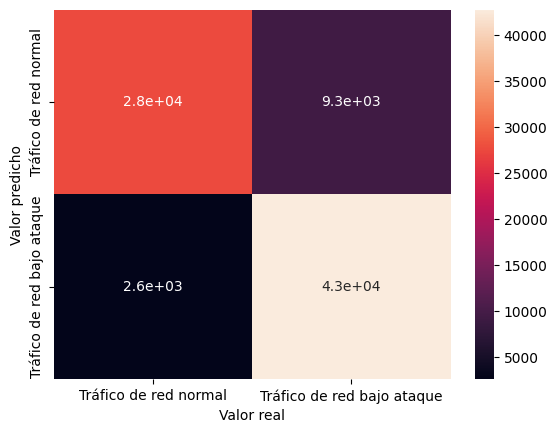

In [370]:
matrix = sns.heatmap(result, annot=True, xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels)
_ = matrix.set(xlabel="Valor real", ylabel="Valor predicho")

### Matriz de confusión que muestra el porcentaje de datos clasificados por filas
-----

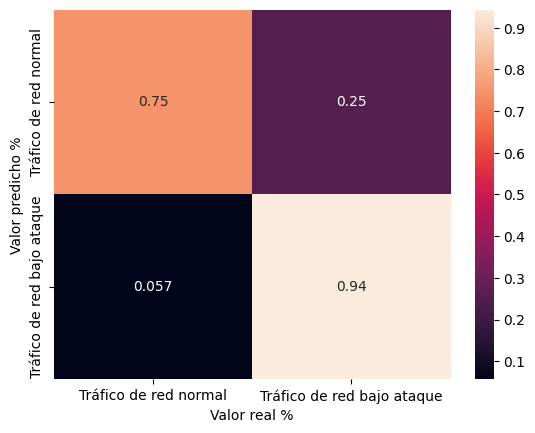

In [371]:
porcentaje = result / np.sum(result, axis=1).reshape(2,1)
matrix = sns.heatmap(porcentaje, annot=True, xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels)
_ = matrix.set(xlabel="Valor real %", ylabel="Valor predicho %")

## Comparación equiparable a la realizada en el paper https://www.researchgate.net/publication/320944473_Towards_Developing_Network_forensic_mechanism_for_Botnet_Activities_in_the_IoT_based_on_Machine_Learning_Techniques
-----

### Se obtiene el conjunto de datos total al combinar los datasets de entrenamiento, validación y prueba
-----

In [372]:
paper_comparison_features = np.concatenate((train_features, test_features))

In [373]:
paper_comparison_labels = np.concatenate((train_labels, test_labels))

### Se realiza la predicción
-----

In [374]:
paper_comparison_predict = best_model.predict(paper_comparison_features)

8053/8053 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [375]:
print(paper_comparison_predict)

[[0.66173965]
 [0.878541  ]
 [0.8643424 ]
 ...
 [0.86379534]
 [0.64695966]
 [0.1701056 ]]


### Se etiquetan las probabilidades con las etiquetas de la clase a la que pertenecen, utilizando un umbral
-----

In [376]:
#transformar probabilidades en enteros
paper_comparison_predict_labels = np.array([1 if x >= 0.5 else 0 for x in paper_comparison_predict.flatten()], dtype=np.float32)

In [377]:
print(len(paper_comparison_predict_labels))

257673


### Se obtienen las métricas de clasificación
-----

In [378]:
print(classification_report(paper_comparison_labels, paper_comparison_predict_labels))

              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86     93000
         1.0       0.91      0.94      0.92    164673

    accuracy                           0.90    257673
   macro avg       0.90      0.88      0.89    257673
weighted avg       0.90      0.90      0.90    257673



### Se obtienen las matrices de confusión
-----

In [379]:
paper_comparison_result = confusion_matrix(paper_comparison_labels, paper_comparison_predict_labels)
print(paper_comparison_result)

[[ 76978  16022]
 [  9577 155096]]


#### Matriz de confusión que muestra la cantidad de datos clasificados
-----

In [380]:
confusion_matrix_labels = ['Tráfico de red normal', 'Tráfico de red bajo ataque']

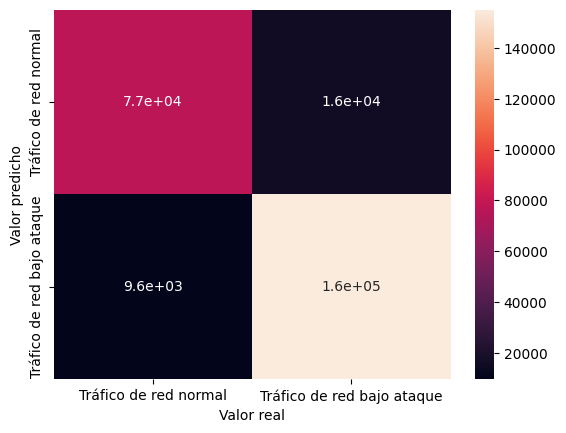

In [381]:
paper_comparison_matrix = sns.heatmap(paper_comparison_result, annot=True, xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels)
_ = paper_comparison_matrix.set(xlabel="Valor real", ylabel="Valor predicho")

#### Matriz de confusión que muestra el porcentaje de datos clasificados por filas
-----

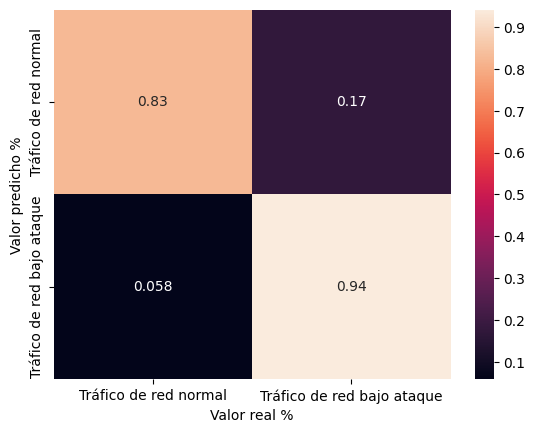

In [382]:
paper_comparison_porcentaje = paper_comparison_result / np.sum(paper_comparison_result, axis=1).reshape(2,1)
paper_comparison_matrix = sns.heatmap(paper_comparison_porcentaje, annot=True, xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels)
_ = paper_comparison_matrix.set(xlabel="Valor real %", ylabel="Valor predicho %")